# System Reliablity Assessment for Security of Supply
---
Title: Power system relianbility modelling v1   
Authors: Dr Wei Sun (w.sun@ed.ac.uk), Yifan Wang   
Date: 17-Nov-2022   
<!-- --- -->

In [1]:
import os
from dotenv import find_dotenv, load_dotenv
load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs

import data_reader_writer

## Setting up simulation

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [3]:
# write csv files for import
start = '2030-01-01 00:00:00'
end = '2030-01-31 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour
time_step = 1.

Choose from one of the National Grid Future Energy Scenarios.

In [4]:
scenario = 'Leading The Way'
# scenario = 'Consumer Transformation'
# scenario = 'System Transformation'
# scenario = 'Steady Progression'

Choose a baseline year (from 2010-2020). The baseline year determines which historical load profile and weather dataset is used for the future year modelled. The National Grid FES modellers used 2012 as their baseline year.

In [5]:
year_baseline = 2020
# delet all except links

data_reader_writer is a script written to read in data from the various sources and write csv files in the format required for populating a PyPSA network object

In [ ]:
data_reader_writer.data_writer(start, end, time_step, year, year_baseline=year_baseline,
                               scenario=scenario, merge_generators=True)

In [7]:
network = pypsa.Network()
network.import_from_csv_folder('LOPF_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
       'Tidal lagoon Penwortham', 'Tidal lagoon S.W.Penisula',
       'Tidal stream Deeside', 'Tidal stream Harker', 'Tidal stream Lovedean',
       'Tidal stream Melksham', 'Tidal stream Penwortham',
       'Tidal stream S.W.Penisula', 'Wave power Beauly', 'Wave power Melksham',
       'Wave power Neilston'],
      dtype='object', name='Generator') for attribute p_max_pu of Generator are not in main components dataframe generators
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, links, loads, storage_units


## System reliablity modelling for security of supply.
The method of  power system reliability modeling is based on Capacity Outage Probability Table
(ref: )

Input Description:
- GENERATOR CAPACITIES is the  capacity of each generator
- GENERATOR OUTAGE is corresponding Forced Outage Rate (EFORd) for each generator (namely, the breakdown rate)

Output Description:
- LOLP: [System Capacity Available, State Probabilities]
- LOLE

## Generation type conversion for breakdown rate

The breakdown rates from National Grid Winter Outlook only include the main generation types. The generation types considered in pypsa-gb are much more that that. Therefore, mapping is needed and provided below.

For wind and other similar weather-dependent generation, they are labeled as 'weather dependent', as their output/contribution will be givenlater using the acctually generation profile time series.

For any type that are reckoned to be excluded at the lolp calculation, they are labeled as 'exlcuded'


In [8]:
bd_conversion_type = [['Coal', 'Nuclear', 'Oil', 'Wind Offshore', 'Wind Onshore', 'Solar Photovoltaics', 'Large Hydro', 'Small Hydro', 'Anaerobic Digestion', 'EfW Incineration', 'Landfill Gas', 'Sewage Sludge Digestion', 'Shoreline Wave', 'Tidal Barrage and Tidal Stream', 'Biomass (co-firing)', 'Biomass (dedicated)','Pumped Storage Hydroelectric', 'Battery', 'Compressed Air', 'Liquid Air','Interconnector',
                       'CCS Gas', 'CCS Biomass', 'Hydrogen', 'Unmet Load', 'Tidal lagoon', 'Tidal stream', 'Wave power'],
                      ['Coal', 'Nuclear', 'OCGT', 'Weather Dependent', 'Weather Dependent', 'Weather Dependent', 'Hydro', 'Hydro', 'Biomass', 'Biomass', 'Biomass', 'Biomass', 'Excluded', 'Excluded', 'Biomass', 'Biomass','Pumped storage', 'Battery', 'CCGT', 'CCGT','Excluded',
                       'CCGT', 'Biomass', 'CCGT', 'Excluded', 'Excluded', 'Excluded', 'Excluded']]

In [9]:
bd_conversion_type_csv = pd.DataFrame(bd_conversion_type).T
bd_conversion_type_csv

,0,1
0,Coal,Coal
1,Nuclear,Nuclear
2,Oil,OCGT
3,Wind Offshore,Weather Dependent
4,Wind Onshore,Weather Dependent
5,Solar Photovoltaics,Weather Dependent
6,Large Hydro,Hydro
7,Small Hydro,Hydro
8,Anaerobic Digestion,Biomass
9,EfW Incineration,Biomass


## Breakdown rate table

This is based on NG winter outlook. It would be subject to changes based on the users' knowledges or more updated information.  
Reference: https://www.nationalgrideso.com/document/268346/download page 12     
Battery reference: https://www.emrdeliverybody.com/Lists/Latest%20News/Attachments/150/Duration%20Limited%20Storage%20De-Rating%20Factor%20Assessment%20-%20Final.pdf page 4    

In [10]:
breakdowwn_rate = {
    'Coal': 0.1,
    'CCGT': 0.06,
    'Nuclear': 0.1,
    'OCGT': 0.07,
    'Biomass': 0.06,
    'Hydro': 0.08,
    'Wind': 0.16,
    'Pumped storage': 0.03, # arbitrary, need to update
    'Weather Dependent': 0,
    'Excluded': 1
}
br_csv = pd.DataFrame.from_dict(breakdowwn_rate,orient='index',columns=['Breakdown Rate'])
br_csv = br_csv.reset_index().rename(columns = {'index':'Type'})
br_csv

,Type,Breakdown Rate
0,Coal,0.10
1,CCGT,0.06
2,Nuclear,0.10
3,OCGT,0.07
4,Biomass,0.06
5,Hydro,0.08
6,Wind,0.16
7,Pumped storage,0.03
8,Weather Dependent,0.00
9,Excluded,1.00


In [11]:
breakdowwn_rate_battery = {
    '0.5h': 0.1789,
    '1.0h': 0.3644,
    '1.5h': 0.5228,
    '2.0h': 0.6479,
    '2.5h': 0.7547,
    '3.0h': 0.8203,
    '3.5h':0.8575,
    '4.0h': 0.9611 # 4+h
}
brb_csv = pd.DataFrame.from_dict(breakdowwn_rate_battery,orient='index',columns=['Breakdown Rate'])
brb_csv = brb_csv.reset_index().rename(columns = {'index':'Duration'})
brb_csv

,Duration,Breakdown Rate
0,0.5h,0.1789
1,1.0h,0.3644
2,1.5h,0.5228
3,2.0h,0.6479
4,2.5h,0.7547
5,3.0h,0.8203
6,3.5h,0.8575
7,4.0h,0.9611


## De-rate table 

Reference: https://www.nationalgrideso.com/document/268356/download

In [12]:
de_conversion_type = [['Coal', 'Nuclear', 'Oil', 'Wind Offshore', 'Wind Onshore', 'Solar Photovoltaics', 'Large Hydro', 'Small Hydro', 'Anaerobic Digestion', 'EfW Incineration', 'Landfill Gas', 'Sewage Sludge Digestion', 'Shoreline Wave', 'Tidal Barrage and Tidal Stream', 'Biomass (co-firing)', 'Biomass (dedicated)','Pumped Storage Hydroelectric', 'Battery', 'Compressed Air', 'Liquid Air','Interconnector', 
                       'CCS Gas', 'CCS Biomass', 'Hydrogen', 'Unmet Load', 'Tidal lagoon', 'Tidal stream', 'Wave power'],
                      ['Coal', 'Nuclear', 'OCGT', 'Wind', 'Wind', 'Solar', 'Hydro', 'Hydro', 'Waste', 'Waste', 'Waste', 'Waste', 'Marine', 'Marine', 'Biomass', 'Biomass','Pumped storage', 'Battery storage', 'OCGT', 'OCGT','Interconnector',
                       'CCGT', 'Biomass', 'CCGT', 'Excluded', 'Marine', 'Marine', 'Marine']]

In [13]:
de_conversion_type_csv = pd.DataFrame(de_conversion_type).T
#bd_conversion_type_csv.to_csv('../data/de_conversion_type.csv',index=False)

In [14]:
de_conversion_type_csv

,0,1
0,Coal,Coal
1,Nuclear,Nuclear
2,Oil,OCGT
3,Wind Offshore,Wind
4,Wind Onshore,Wind
5,Solar Photovoltaics,Solar
6,Large Hydro,Hydro
7,Small Hydro,Hydro
8,Anaerobic Digestion,Waste
9,EfW Incineration,Waste


In [15]:
de_rate = {
    'Biomass': 0.88,
    'Waste': 0.745, # average for various
    'Coal': 0.76,
    'CCGT': 0.913, # CHP/cogeneration 
    'OCGT': 0.952, # gas & diesel reciprocating engines
    'Nuclear': 0.744,
    'Battery storage': 0.597,
    'Pumped storage': 0.952,
    'Hydro': 0.911,
    'Solar': 0.022,
    'Marine': 0.22,
    'Wind': 0.174, #offshore & onshore
    'DSR': 0.715,
    'Interconnector': 0.099,
    'Excluded': 0
}
de_csv = pd.DataFrame.from_dict(de_rate,orient='index',columns=['De-Rate'])
de_csv = de_csv.reset_index().rename(columns = {'index':'Type'})
de_csv

,Type,De-Rate
0,Biomass,0.880
1,Waste,0.745
2,Coal,0.760
3,CCGT,0.913
4,OCGT,0.952
5,Nuclear,0.744
6,Battery storage,0.597
7,Pumped storage,0.952
8,Hydro,0.911
9,Solar,0.022


In [16]:
# this just provide a option to read breakdown rate table from a .csv file, 
# rather than hard-coded in the notebook
import os
if not os.path.exists('../data/LOLE'):
    os.makedirs('../data/LOLE')
bd_conversion_type_csv.to_csv('../data/LOLE/bd_conversion_type.csv',index=False)
br_csv.to_csv('../data/LOLE/breakdown_rate.csv',index=False)
brb_csv.to_csv('../data/LOLE/breakdowwn_rate_battery.csv',index=False)
de_conversion_type_csv.to_csv('../data/LOLE/de_conversion_type.csv',index=False)
de_csv.to_csv('../data/LOLE/de_rate.csv',index=False)

In [17]:
system_reserve_requirment = 1200 #MW, from NG winter outlook 2022

## Calculate system margin, LOLP and LOLE

In [18]:
def get_rate(row, name_list, carrier, conversion_dict, power_stations, breakdown_rate, breakdowwn_rate_battery=None, storage_units= None):
    for i in range(len(carrier)):
        # if row[i] != [0]: only running stations
        name = name_list[i]
        fuel_type = convert_type(name, carrier, conversion_dict, power_stations)
        if fuel_type != 'Battery':
            rate = breakdown_rate[fuel_type]
        else:
            max_hours = storage_units[storage_units.index == name]['max_hours'].tolist()[0]
            max_hours = np.rint(max_hours * 2) / 2
            max_hours = min(max_hours, 4)
            rate = breakdowwn_rate_battery[str(max_hours) + 'h']        
        row[i] = rate
    return row

In [19]:
def convert_type(name, carrier, conversion_dict, power_stations):
    type0 = carrier[name]
    try:
        type1 = conversion_dict[type0]
    except:
        if type0 == 'Natural Gas':
            type1 = power_stations[power_stations['Station Name']==name]['Technology'].tolist()[0]
        else:
            type1 = 'Excluded'
#             if 'new_type_list' not in globals():
#                 global new_type_list
#                 new_type_list = list()
#             if type0 not in new_type_list:
#                 new_type_list.append(type0)
            print('Do not have break downrate for type ' + type0)
    return type1

In [20]:
#  calculate lolp without running opf/uc
def LOLP(network, year, year_baseline=None):
    
    # rate
    if year > 2020:
        year = year_baseline
    file = '../data/power stations/power_stations_locations_' + str(year) + '.csv'
    power_stations = pd.read_csv(file, encoding='unicode_escape')
    
    bd_conversion_csv = pd.read_csv('../data/LOLE/bd_conversion_type.csv',index_col=0)
    bd_conversion_dict = bd_conversion_csv.to_dict()['1']
    
    breakdown_rate = pd.read_csv('../data/LOLE/breakdown_rate.csv',index_col=0)
    breakdown_rate = breakdown_rate.to_dict()['Breakdown Rate']
    breakdowwn_rate_battery = pd.read_csv('../data/LOLE/breakdowwn_rate_battery.csv',index_col=0)
    breakdowwn_rate_battery = breakdowwn_rate_battery.to_dict()['Breakdown Rate']
    
    
    generators_name_list = network.generators.index.tolist() ##
    
    #  generator units' breakdown rate time-series dataframe: generators_rate
    generators_rate_col = generators_name_list
    generators_rate_index = network.snapshots.copy()
    generators_rate = pd.DataFrame(columns=generators_rate_col, index=generators_rate_index) 
    generators_rate.apply(lambda r: get_rate(r, generators_name_list, network.generators.carrier, bd_conversion_dict, power_stations, breakdown_rate), axis = 1)
    
    # storage units' breakdown rate time-series dataframe: storage_rate
    storage_units_name_list = network.storage_units.index.tolist() 
    storage_units_rate_col = storage_units_name_list
    storage_units_rate_index = network.snapshots.copy()
    storage_units_rate = pd.DataFrame(columns=storage_units_rate_col, index=storage_units_rate_index) ##
    storage_units_rate.apply(lambda r: get_rate(r, storage_units_name_list, network.storage_units.carrier, bd_conversion_dict, power_stations, breakdown_rate, breakdowwn_rate_battery, network.storage_units), axis = 1)
    
    # all units' breakdown rate
    pd_rate = pd.concat([generators_rate, storage_units_rate], axis=1)
    # pd_rate2 = pd_rate.copy()
    
    # caculate time series of weather dependent generators' outputs from input data 

    pd_stations = pd_rate.copy()
    pd_stations_w = pd_stations[network.generators.index.tolist()][(pd_rate == 0)].dropna(axis=1,how='all').fillna(0)
    pd_stations[network.generators.p_nom.index] = network.generators.p_nom.values
    pd_stations[network.storage_units.p_nom.index] = network.storage_units.p_nom.values
    pd_stations[pd_stations_w.columns] = network.generators_t.p_max_pu[pd_stations_w.columns] * network.generators.p_nom[pd_stations_w.columns]

    pd_stations_all = pd_stations.copy()
    
    pd_stations_w = pd_stations[network.generators.index.tolist()][(pd_rate == 0)].dropna(axis=1,how='all').fillna(0)
    ## Shoreline Wave, Tidal Barrage and Tidal Stream

    pd_stations = pd_stations[(pd_rate < 1) & (pd_rate > 0)].dropna(axis=1,how='all').fillna(0)
    
    # Note: now, the time series of breakdown rate ONLY include non weather dependent units (i.e. convertional units)
    pd_rate = pd_rate[(pd_rate < 1) & (pd_rate > 0)].dropna(axis=1,how='all').fillna(0)
    
    # net_demand
    # calculate net_demand from input data (value is empty)
    # net_demand = total demand - renewable (Weather Dependent) output.
    net_demand = network.loads_t.p_set.sum(axis=1) - pd_stations_w.sum(axis=1)
    
    
    # non renewable generator units' installed capacity
    installed_capacity = pd.concat([network.generators.p_nom, network.storage_units.p_nom], axis=0)[pd_stations.columns].to_numpy()
    
    return installed_capacity, pd_rate.to_numpy()[0], net_demand, pd_stations_all, pd_stations_w
    

In [21]:
def Margin(network, pd_stations,year, system_reserve_requirment, year_baseline=None):

    # rate
    if year > 2020:
        year = year_baseline
    file = '../data/power stations/power_stations_locations_' + str(year) + '.csv'
    power_stations = pd.read_csv(file, encoding='unicode_escape')
    
    de_conversion_csv = pd.read_csv('../data/LOLE/de_conversion_type.csv',index_col=0)
    de_conversion_dict = de_conversion_csv.to_dict()['1']
    
    de_rate = pd.read_csv('../data/LOLE/de_rate.csv',index_col=0)
    de_rate = de_rate.to_dict()['De-Rate']
    
    generators_name_list = network.generators.index.tolist() ##
    
    #  generator units' breakdown rate time-series dataframe: generators_rate
    generators_rate_col = generators_name_list
    generators_rate_index = network.snapshots.copy()
    generators_rate = pd.DataFrame(columns=generators_rate_col, index=generators_rate_index) 
    generators_rate.apply(lambda r: get_rate(r, generators_name_list, network.generators.carrier, de_conversion_dict, power_stations, de_rate), axis = 1)
    
    # storage units' breakdown rate time-series dataframe: storage_rate
    storage_units_name_list = network.storage_units.index.tolist() 
    storage_units_rate_col = storage_units_name_list
    storage_units_rate_index = network.snapshots.copy()
    storage_units_rate = pd.DataFrame(columns=storage_units_rate_col, index=storage_units_rate_index) ##
    storage_units_rate.apply(lambda r: get_rate(r, storage_units_name_list, network.storage_units.carrier, de_conversion_dict, power_stations, de_rate), axis = 1)
    
    # all units' breakdown rate
    pd_rate = pd.concat([generators_rate, storage_units_rate], axis=1) 
    
    # caculate time series of weather dependent generators' outputs from input data 

    pd_installed_capacity = pd.concat([network.generators.p_nom, network.storage_units.p_nom], axis=0)
    de_rated_capacity = (pd_installed_capacity * pd_rate).sum(axis =1)[0]
    margin = de_rated_capacity - network.loads_t.p_set.sum(axis=1) - system_reserve_requirment # reserve
    
    return de_rated_capacity, margin

In [22]:
installed_capacity, breakdwon_rate, net_demand, pd_stations_all, pd_stations_w = LOLP(network, year, year_baseline=year_baseline)

In [23]:
de_rated_capacity, margin = Margin(network, pd_stations_all, year, system_reserve_requirment, year_baseline=year_baseline)

In [24]:
de_rated_capacity

59494.63367109998

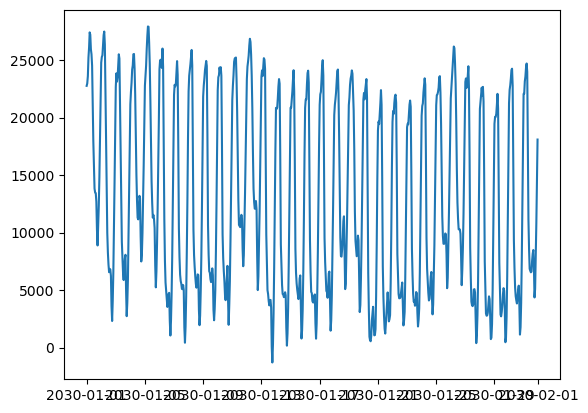

In [25]:
plt.plot(margin)

In [26]:
margin.describe()

count      744.000000
mean     12907.155837
std       8216.663883
min      -1287.471570
25%       5157.775300
50%      11168.368018
75%      21595.562659
max      27930.359528
dtype: float64

In [27]:
network.loads_t.p_set.sum(axis=1).describe()

count      744.000000
mean     45387.477834
std       8216.663883
min      30364.274143
25%      36699.071012
50%      47126.265653
75%      53136.858371
max      59582.105241
dtype: float64

Small generator units can be exlcuded from lolp calculation if necessary (i.e. assuming they are not contributing to reliability analysis)

In [28]:
def split_generators(installed_capacity, breakdwon_rate, num = None, value = 0, Round = False):
    if num == None:
        num = installed_capacity.shape[0]
    sorted_capacity = np.sort(installed_capacity[installed_capacity >= value])
    boundary = sorted_capacity[max(sorted_capacity.shape[0] - num, 0)]
    large_capacity = np.copy(installed_capacity[installed_capacity >= boundary])
    large_breakdwon_rate = np.copy(breakdwon_rate[installed_capacity >= boundary])
    expect_small_capacity = sum(installed_capacity[installed_capacity < boundary] * (1 - breakdwon_rate[installed_capacity < boundary]))
    if Round:
        large_capacity = np.rint(large_capacity)
    print('Number of laege generators: ' + str(large_capacity.shape[0]))
    print('Boundary: ' + str(boundary))
    
    return large_capacity, large_breakdwon_rate, expect_small_capacity

In [29]:
# exclude any generator small than 50 WM (criteria would be subject to change)
large_capacity, large_breakdwon_rate, expect_small_capacity = split_generators(installed_capacity, breakdwon_rate, value = 50, Round=True)


Number of laege generators: 126
Boundary: 50.83


## Calculating PDF and CDF of power supply based on breakdown rate

In [30]:
def dict_add(A,B):
    for key,value in B.items():
        try:
            A[key] += value
        except:
            A[key] = value
    return A

In [31]:
pdf = dict()
pdf[0] = 1

for i in range(large_capacity.shape[0]):
    prob_down = dict()
    prob_up = dict()
    
    for key,value in pdf.items():
        avail_value = np.float64(key)+large_capacity[i]
        try:
            prob_up[avail_value] += value * (1-large_breakdwon_rate[i])
        except:
            prob_up[avail_value] = value * (1-large_breakdwon_rate[i])
        try:
            prob_down[key] += value * large_breakdwon_rate[i]
        except:
            prob_down[key] = value * large_breakdwon_rate[i]
    pdf = dict_add(prob_up,prob_down)
    
pdf = dict(sorted(pdf.items(),key=lambda d:d[0]))

In [32]:
xx = sorted(pdf)
len(xx)

51721

In [33]:
# calculating cdf of power supply (x-axis is power supply MW, y-axis is the probility)
yy = np.zeros(len(xx))
cdf = np.zeros(len(xx))
cdf_i = 0
for i in range(len(pdf)):
    key = xx[i]
    yy[i] = pdf[key]
    cdf_i += yy[i]
    cdf[i] = cdf_i
    

## plot and prettify the PDF of system generation capacity available

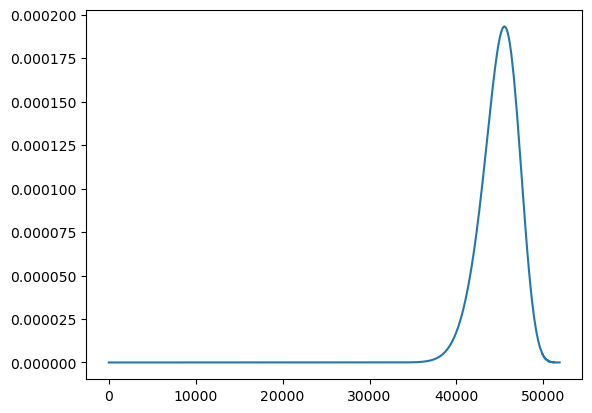

In [34]:
plt.plot(xx,yy)

In [35]:
np.mean(net_demand)

-6305.212350730428

(29878.0, 53878.0)

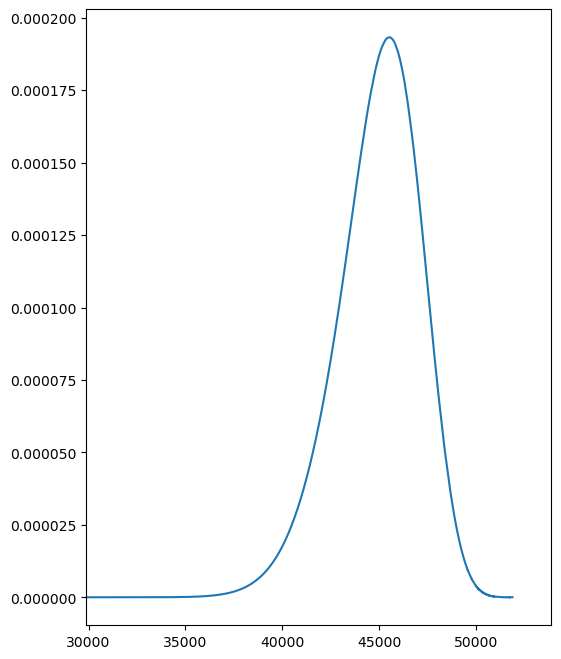

In [36]:
plt.figure(figsize=(6,8))
plt.plot(xx,yy)
plt.xlim(max(xx)-22000,max(xx)+2000)

In [37]:
int_x = [round(x/100)*100 for x in xx]

(29878.0, 53878.0)

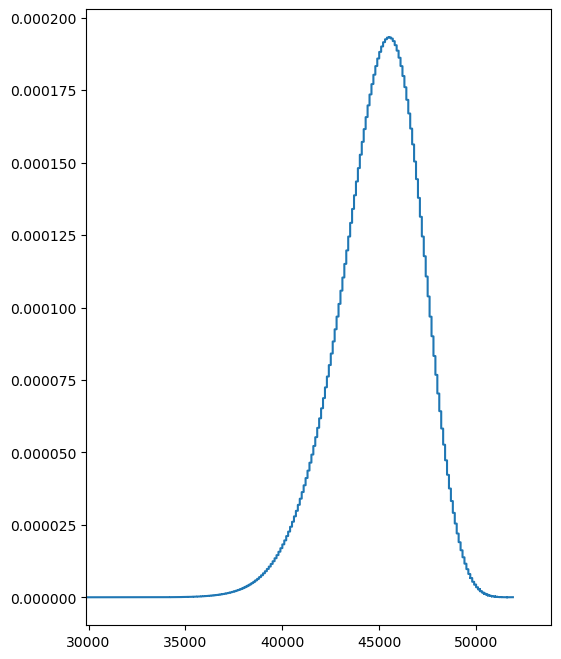

In [38]:
plt.figure(figsize=(6,8))
plt.plot(int_x,yy)
plt.xlim(max(xx)-22000,max(xx)+2000)

## plot CDF of ystem generation capacity available

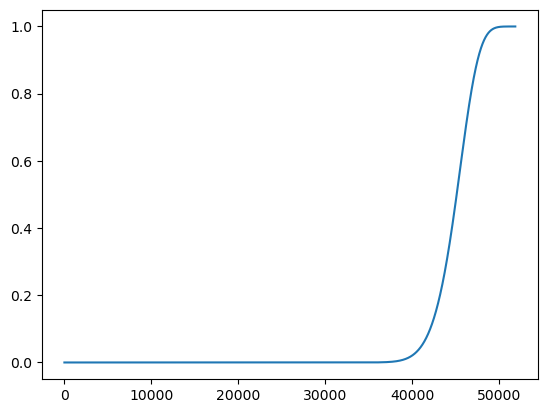

In [39]:
plt.plot(xx,cdf)

## calculating the LOLP at each time step

In [40]:
lolp = list()
for i in range(len(net_demand)):
    lolp.append(yy[xx<net_demand[i] - expect_small_capacity + system_reserve_requirment].sum())

In [41]:
lolp_min = np.where(lolp == min(lolp))
network.snapshots[lolp_min[0][0]]

Timestamp('2030-01-01 00:00:00')

In [42]:
lolp_max = np.where(lolp == max(lolp))
network.snapshots[lolp_max[0][0]]

Timestamp('2030-01-09 18:00:00')

## calculating the LOLE over the whole period

In [43]:
lole = sum(lolp)
print(f'the loss load expectation (LOLE) for the considered period are {lole} hours; the current UK regulation for LOLE is below 3 hours per year')

the loss load expectation (LOLE) for the considered period are 0.3837036857081899 hours; the current UK regulation for LOLE is below 3 hours per year


In [44]:
# test lole changes with adding increased firm capacity 
for i_ in range(1,10):
    lolp = list()
    for i in range(len(net_demand)):
        lolp.append(yy[xx<net_demand[i]-expect_small_capacity+system_reserve_requirment-i_*500].sum())
    lole = sum(lolp)
    print(f'for {i_*500}MW increased firm capacity, lole is {lole}')

for 500MW increased firm capacity, lole is 0.253912752776933
for 1000MW increased firm capacity, lole is 0.16449020523068544
for 1500MW increased firm capacity, lole is 0.1042692047400952
for 2000MW increased firm capacity, lole is 0.06464530407593015
for 2500MW increased firm capacity, lole is 0.0391822407506297
for 3000MW increased firm capacity, lole is 0.023206790534456186
for 3500MW increased firm capacity, lole is 0.013424981725931939
for 4000MW increased firm capacity, lole is 0.0075821160566627
for 4500MW increased firm capacity, lole is 0.004178956710335652


## Wind-shock scenario
### Largest offshore wind farm failure 

In [45]:
largest_windfarm = network.generators_t.p_max_pu[network.generators.p_nom[network.generators.p_nom<999999999].idxmax()] * network.generators.p_nom[network.generators.p_nom<999999999].max()

In [46]:
largest_windfarm

snapshot
2030-01-01 00:00:00    10458.369586
2030-01-01 01:00:00    10975.644353
2030-01-01 02:00:00    11359.897019
2030-01-01 03:00:00    11549.150509
2030-01-01 04:00:00    11847.434004
                           ...     
2030-01-31 19:00:00    12826.469674
2030-01-31 20:00:00    13547.523877
2030-01-31 21:00:00    13885.768434
2030-01-31 22:00:00    13890.536122
2030-01-31 23:00:00    13873.669389
Name: Wind Offshore Peterhead, Length: 744, dtype: float64

In [47]:
net_demand = net_demand +  largest_windfarm

In [48]:
lolp = list()
for i in range(len(net_demand)):
    lolp.append(yy[xx<net_demand[i]-expect_small_capacity+system_reserve_requirment].sum())

In [49]:
lole = sum(lolp)
print(f'the loss load expectation (LOLE) for the considered period are {lole} hours; the current UK regulation for LOLE is below 3 hours per year')

the loss load expectation (LOLE) for the considered period are 5.215013694141864 hours; the current UK regulation for LOLE is below 3 hours per year


### Long period of low RES power scenario

In [50]:
# simply adding a de-rate facor of 0.8 to the output of renewable generation at all time.
net_demand = network.loads_t.p_set.sum(axis=1) - pd_stations_w.sum(axis=1) * 0.8

In [51]:
lolp = list()
for i in range(len(net_demand)):
    lolp.append(yy[xx<net_demand[i]-expect_small_capacity+system_reserve_requirment].sum())

In [52]:
lole = sum(lolp)
print(f'the loss load expectation (LOLE) for the considered period are {lole} hours; the current UK regulation for LOLE is below 3 hours per year')

the loss load expectation (LOLE) for the considered period are 2.2590173463497942 hours; the current UK regulation for LOLE is below 3 hours per year
